## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 15 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
opt=["SGD","Adam","RMS"]
"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0, 0.25, 0.5, 0.8]
redice_lr_patient = [5, 20]

In [15]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 4s 79us/step - loss: 2.2265 - accuracy: 0.2634 - val_loss: 2.1134 - val_accuracy: 0.1929
Epoch 2/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.7420 - accuracy: 0.3950 - val_loss: 1.9767 - val_accuracy: 0.2830
Epoch 3/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.6233 - accuracy: 0.4324 - val_loss: 1.8204 - val_accuracy: 0.3794
Epoch 4/15
50000/50000 [==============================] - 4s 70us/step - loss: 1.5543 - accuracy: 0.4557 - val_loss: 1.7210 - val_accuracy: 0.4080
Epoch 5/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.5019 - accuracy: 0.4736 - val_loss: 1.6462 - val_accuracy: 0.4255
Epoch 6/15
50000/50000 [==============================] - 3s 70us/step - loss: 1.4571 - accuracy: 0.4899 - val_loss: 1.5842 - val_accuracy: 0.4466
Epoch 7/15
50000/50000 [==============================] - 3s 70us/st

50000/50000 [==============================] - 3s 69us/step - loss: 1.4847 - accuracy: 0.4820 - val_loss: 1.6568 - val_accuracy: 0.4158
Epoch 6/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.4402 - accuracy: 0.4964 - val_loss: 1.5810 - val_accuracy: 0.4438
Epoch 7/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.4014 - accuracy: 0.5108 - val_loss: 1.5564 - val_accuracy: 0.4461
Epoch 8/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.3659 - accuracy: 0.5248 - val_loss: 1.5183 - val_accuracy: 0.4640
Epoch 9/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.3342 - accuracy: 0.5353 - val_loss: 1.5019 - val_accuracy: 0.4717
Epoch 10/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.3042 - accuracy: 0.5461 - val_loss: 1.4965 - val_accuracy: 0.4631
Epoch 11/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.2770 - accuracy: 0.5574 - val_loss: 1.4737 - v

Epoch 10/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.3117 - accuracy: 0.5425 - val_loss: 1.4927 - val_accuracy: 0.4712
Epoch 11/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.2826 - accuracy: 0.5563 - val_loss: 1.4795 - val_accuracy: 0.4729
Epoch 12/15
50000/50000 [==============================] - 3s 69us/step - loss: 1.2555 - accuracy: 0.5659 - val_loss: 1.4805 - val_accuracy: 0.4743
Epoch 13/15
50000/50000 [==============================] - 3s 66us/step - loss: 1.2302 - accuracy: 0.5734 - val_loss: 1.4584 - val_accuracy: 0.4856
Epoch 14/15
50000/50000 [==============================] - 3s 66us/step - loss: 1.2056 - accuracy: 0.5837 - val_loss: 1.4636 - val_accuracy: 0.4812
Epoch 15/15
50000/50000 [==============================] - 3s 66us/step - loss: 1.1824 - accuracy: 0.5928 - val_loss: 1.4689 - val_accuracy: 0.4855
Numbers of exp: 7, reduce_factor: 0.80, reduce_patient: 20
Model: "model_11"
___________________________________

50000/50000 [==============================] - 4s 70us/step - loss: 0.9331 - accuracy: 0.6765 - val_loss: 1.3784 - val_accuracy: 0.5231
Epoch 15/15
50000/50000 [==============================] - 4s 70us/step - loss: 0.9337 - accuracy: 0.6774 - val_loss: 1.3625 - val_accuracy: 0.5287
Numbers of exp: 9, reduce_factor: 0.00, reduce_patient: 20
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_37 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 4s 83us/step - loss: 2.9209 - accuracy: 0.1098 - val_loss: 2.3067 - val_accuracy: 0.1141
Epoch 2/15
50000/50000 [==============================] - 4s 74us/step - loss: 2.9213 - accuracy: 0.1099 - val_loss: 2.3298 - val_accuracy: 0.1231
Epoch 3/15
50000/50000 [==============================] - 4s 75us/step - loss: 2.9226 - accuracy: 0.1099 - val_loss: 2.3679 - val_accuracy: 0.1239
Epoch 4/15
50000/50000 [==============================] - 4s 73us/step - loss: 2.9217 - accuracy: 0.1101 - val_loss: 2.4183 - val_accuracy: 0.1179
Epoch 5/15
50000/50000 [==============================] - 4s 71us/step - loss: 2.9220 - accuracy: 0.1105 - val_loss: 2.4770 - val_accuracy: 0.1148
Epoch 6/15
50000/50000 [==============================] - 4s 72us/step - loss: 2.9217 - accuracy: 0.1097 - val_loss: 2.5394 - val_accuracy: 0.1093
Epoch 7/15
50000/50000 [==============================] - 4s 72us/st

50000/50000 [==============================] - 4s 76us/step - loss: 3.0285 - accuracy: 0.0953 - val_loss: 2.5927 - val_accuracy: 0.0921
Epoch 6/15
50000/50000 [==============================] - 4s 77us/step - loss: 3.0294 - accuracy: 0.0962 - val_loss: 2.6542 - val_accuracy: 0.0902
Epoch 7/15
50000/50000 [==============================] - 4s 77us/step - loss: 3.0295 - accuracy: 0.0959 - val_loss: 2.7127 - val_accuracy: 0.0905
Epoch 8/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0285 - accuracy: 0.0956 - val_loss: 2.7678 - val_accuracy: 0.0925
Epoch 9/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0290 - accuracy: 0.0958 - val_loss: 2.8184 - val_accuracy: 0.0929
Epoch 10/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0285 - accuracy: 0.0949 - val_loss: 2.8629 - val_accuracy: 0.0938
Epoch 11/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0296 - accuracy: 0.0955 - val_loss: 2.9017 - v

Epoch 10/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0925 - accuracy: 0.0876 - val_loss: 2.9348 - val_accuracy: 0.0896
Epoch 11/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0938 - accuracy: 0.0869 - val_loss: 2.9721 - val_accuracy: 0.0898
Epoch 12/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0932 - accuracy: 0.0868 - val_loss: 3.0025 - val_accuracy: 0.0915
Epoch 13/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0934 - accuracy: 0.0871 - val_loss: 3.0269 - val_accuracy: 0.0929
Epoch 14/15
50000/50000 [==============================] - 4s 77us/step - loss: 3.0930 - accuracy: 0.0868 - val_loss: 3.0454 - val_accuracy: 0.0925
Epoch 15/15
50000/50000 [==============================] - 4s 76us/step - loss: 3.0923 - accuracy: 0.0866 - val_loss: 3.0590 - val_accuracy: 0.0920
Numbers of exp: 16, reduce_factor: 0.00, reduce_patient: 5
Model: "model_20"
___________________________________

50000/50000 [==============================] - 4s 73us/step - loss: 2.9022 - accuracy: 0.1091 - val_loss: 2.8734 - val_accuracy: 0.1067
Epoch 15/15
50000/50000 [==============================] - 4s 73us/step - loss: 2.9025 - accuracy: 0.1089 - val_loss: 2.8876 - val_accuracy: 0.1062
Numbers of exp: 18, reduce_factor: 0.25, reduce_patient: 5
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_64 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 4s 82us/step - loss: 3.1386 - accuracy: 0.0990 - val_loss: 2.3584 - val_accuracy: 0.0879
Epoch 2/15
50000/50000 [==============================] - 4s 72us/step - loss: 3.1403 - accuracy: 0.0982 - val_loss: 2.4023 - val_accuracy: 0.0979
Epoch 3/15
50000/50000 [==============================] - 4s 74us/step - loss: 3.1383 - accuracy: 0.0985 - val_loss: 2.4727 - val_accuracy: 0.0964
Epoch 4/15
50000/50000 [==============================] - 4s 72us/step - loss: 3.1396 - accuracy: 0.0982 - val_loss: 2.5435 - val_accuracy: 0.0960
Epoch 5/15
50000/50000 [==============================] - 4s 74us/step - loss: 3.1385 - accuracy: 0.0984 - val_loss: 2.6095 - val_accuracy: 0.0970
Epoch 6/15
50000/50000 [==============================] - 4s 72us/step - loss: 3.1397 - accuracy: 0.0982 - val_loss: 2.6739 - val_accuracy: 0.0958
Epoch 7/15
50000/50000 [==============================] - 4s 70us/st

50000/50000 [==============================] - 4s 75us/step - loss: 2.9422 - accuracy: 0.1073 - val_loss: 2.5350 - val_accuracy: 0.1146
Epoch 6/15
50000/50000 [==============================] - 4s 75us/step - loss: 2.9440 - accuracy: 0.1077 - val_loss: 2.5910 - val_accuracy: 0.1121
Epoch 7/15
50000/50000 [==============================] - 4s 76us/step - loss: 2.9430 - accuracy: 0.1071 - val_loss: 2.6445 - val_accuracy: 0.1091
Epoch 8/15
50000/50000 [==============================] - 4s 75us/step - loss: 2.9422 - accuracy: 0.1081 - val_loss: 2.6946 - val_accuracy: 0.1105
Epoch 9/15
50000/50000 [==============================] - 4s 75us/step - loss: 2.9428 - accuracy: 0.1078 - val_loss: 2.7398 - val_accuracy: 0.1119
Epoch 10/15
50000/50000 [==============================] - 4s 74us/step - loss: 2.9426 - accuracy: 0.1076 - val_loss: 2.7793 - val_accuracy: 0.1120
Epoch 11/15
50000/50000 [==============================] - 4s 75us/step - loss: 2.9429 - accuracy: 0.1076 - val_loss: 2.8136 - v

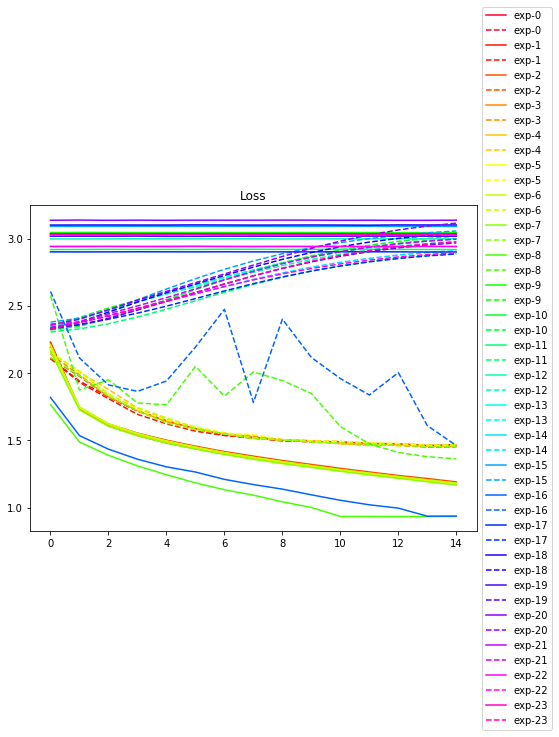

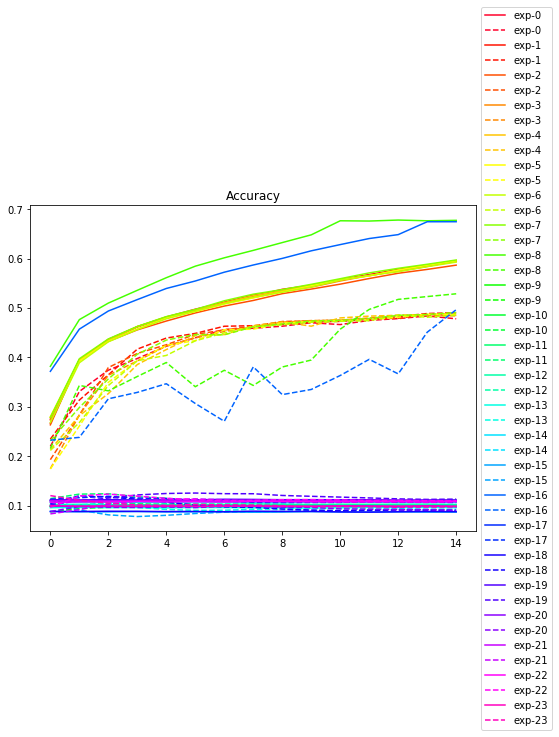

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()